# Reinforcement Learning

В этом задании постараемся разобраться в проблеме обучения с подкреплением, реализуем алгоритм REINFORCE и научим агента с помощью этого алгоритма играть в игру Cartpole.

Установим и импортируем необходимые библиотеки.

In [ ]:
!pip install gym pandas torch matplotlib

In [3]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import numpy as np
import gym
import torch
import collections
import pandas as pd
from torch import nn
from torch.optim import Adam
from torch.distributions import Categorical

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #позволяет перенести тензор на GPU, если он доступен в системе

## OpenAI Gym

[OpenAI Gym](https://gym.openai.com) это набор сред для разработки и сравнения алгоритмов обучения с подкреплением.

OpenAI Gym предоставляет простой и универсальный API ко многим средам с разными свойствами, как простым так и сложным:
* Классические задачи управления и игрушечные примеры, которые можно найти в учебниках и на которых демонстрируется работа алгоритмов обучения с подкреплением (одна из этих сред используется в этом задании)
* Игры Atari (оказали огромное влияние на достижения в обучении с подкреплением в последние годы)
* 2D и 3D среды для контроля роботов в симуляции (используют проприетарный движок [Mojuco](http://www.mujoco.org))

Рассмотрим, как устроена среда [CartPole-v0](https://gym.openai.com/envs/CartPole-v0), с которой мы будем работать.

Для этого создадим среду и выведем ее описание.

In [5]:
env = gym.make("CartPole-v0")
print(env.env.__doc__)


    Description:
        A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The pendulum starts upright, and the goal is to prevent it from falling over by increasing and reducing the cart's velocity.

    Source:
        This environment corresponds to the version of the cart-pole problem described by Barto, Sutton, and Anderson

    Observation: 
        Type: Box(4)
        Num	Observation                 Min         Max
        0	Cart Position             -4.8            4.8
        1	Cart Velocity             -Inf            Inf
        2	Pole Angle                 -24°           24°
        3	Pole Velocity At Tip      -Inf            Inf
        
    Actions:
        Type: Discrete(2)
        Num	Action
        0	Push cart to the left
        1	Push cart to the right
        
        Note: The amount the velocity is reduced or increased is not fixed as it depends on the angle the pole is pointing. This is because the center of gravity o

Из этого описания мы можем узнать, как устроены пространства состояний и действий в этой среды, какие награды получаются на каждом шаге, а также, что нам необходимо сделать, чтобы научиться "решать" эту среду, а именно достич средней награды больше 195.0 или больше за 100 последовательных запусков агента в этой среде. Именно такого агента мы и попробуем создать и обучить.

Но для начала напишем вспомогательную функцию, которая будет принимать на вход среду, агента и число эпизодов, и возвращать среднюю награду за 100 эпизодов. С помощью этой функции мы сможем протестировать, насколько хорошо обучился наш агент, а также визуализировать его поведение в среде.

In [6]:
def test_agent(env, agent=False, render=False, n_episodes=100):
    total_reward = []
    for episode in range(n_episodes):
        episode_reward = 0
        observation = env.reset()
        t = 0
        while True:
            if render:
                env.render()
            if agent:
                with torch.no_grad():
                    probs = agent(torch.FloatTensor(observation)).to(device)
                    dist = Categorical(probs)
                    action = dist.sample().item()
            else:
                action = env.action_space.sample()
            observation, reward, done, info = env.step(action)
            episode_reward += reward
            t += 1
            if done:
                print("Episode {} finished after {} timesteps".format(episode+1, t+1))
                break
        total_reward.append(episode_reward)
        env.close()
                   
    return np.mean(total_reward)

Протестируем и визуализируем случайного агента (параметр ```agent=False```).

In [7]:
test_agent(env, agent=False, render=True, n_episodes=100)

Episode 1 finished after 15 timesteps
Episode 2 finished after 14 timesteps
Episode 3 finished after 14 timesteps
Episode 4 finished after 16 timesteps
Episode 5 finished after 18 timesteps
Episode 6 finished after 16 timesteps
Episode 7 finished after 27 timesteps
Episode 8 finished after 36 timesteps
Episode 9 finished after 20 timesteps
Episode 10 finished after 21 timesteps
Episode 11 finished after 12 timesteps
Episode 12 finished after 16 timesteps
Episode 13 finished after 12 timesteps
Episode 14 finished after 22 timesteps
Episode 15 finished after 21 timesteps
Episode 16 finished after 13 timesteps
Episode 17 finished after 29 timesteps
Episode 18 finished after 12 timesteps
Episode 19 finished after 12 timesteps
Episode 20 finished after 10 timesteps
Episode 21 finished after 34 timesteps
Episode 22 finished after 20 timesteps
Episode 23 finished after 11 timesteps
Episode 24 finished after 25 timesteps
Episode 25 finished after 14 timesteps
Episode 26 finished after 17 times

21.55

Как видно, наш случайный агент выступает не очень хорошо и в среднем может удержать шест всего около 22 шагов.

Попробуем применить обучение с подкреплением и алгоритм REINFORCE для того, чтобы в среднем за 100 эпиздов мы держали шест не менее 195 шагов.

## REINFORCE

Вспомним, что из себя представляет алгоритм REINFORCE (Sutton & Barto) <img src="./images/REINFORCE.png" width="700">

1. Инициализуем политику (в качестве политики мы будем использовать глубокую нейронную сеть).
2. "Играем" в среде эпизод, используя нашу политику, или несколько (мы будем использовать последний вариант) и собираем данные о состояниях, действиях и полученных наградах. 
3. Для каждого состояния в собранных эпизодах вычисляем сумму дисконтированных наград, полученных из этого состояния, а также логорифм правдоподобия предпринятого действия в этом состоянии для нашей политики.
4. Обновляем параметры нашей политики по формуле на схеме.

### Политика

Наша политика должна принимать на вход состояние среды, а на выходе выдавать распределение по действиям, которые мы можем осуществлять в среде.

**Задание:** Создать класс нейронной сети со следующей архитектурой Linear -> ReLU -> Linear -> Softmax. Параметрами инициализации должны служить размерности пространства состояний, пространства действий и размер скрытого слоя.

In [8]:
class Policy(nn.Module):
    def __init__(self, state_size, act_size, hidden_size):
        super(Policy, self).__init__()
        
        self.act = nn.Sequential(
            nn.Linear(state_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, act_size),
            nn.Softmax(),
        )
        
    def forward(self, x):
        return self.act(x)

### Оценка правдоподобия и расчет суммы дисконтированных наград

**Задание:** Напишем вспомогательная функцию, которая принимает на вход политику, батч траекторий и фактор дисконтирования, и должна вернуть следующие величины: 
* правдоподобие действия на каждом шаге на траектории посчитанные для всего батча;
* дисконтированные суммы наград (reward-to-go) из каждого состояния среды на траектории посчитанные для всего батча;

**Hint**: Представим батч траекторий как ```list```, в котром также хранится ```list``` для каждой траектории, в котором каждый шаг хранится, как ```namedtuple```:
```transition = collections.namedtuple("transition", ["state", "action", "reward"])```

In [21]:
def process_traj_batch(policy, batch, discount):
    returns = []
    log_probs = []
    for episode in batch:
        for s, step in enumerate(episode):
            probs = policy(step.state)
            dist = Categorical(probs)
            log_probs.append(dist.log_prob(step.action))
            returns.append(sum(discount**i * t.reward for i, t in enumerate(episode[s:])))        
    return log_probs, returns

### Вспомогательные функции и гиперпараметры

Функция для расчета скользящего среднего - ее мы будем использовать для визуализации наград по эпизодам.

In [10]:
moving_average = lambda x, **kw: pd.DataFrame({'x':np.asarray(x)}).x.ewm(**kw).mean().values

Определим также гиперпараметры.

In [11]:
STATE_SIZE  = env.observation_space.shape[0] # размерность пространства состояний среды
ACT_SIZE = env.action_space.n # размерность пространства действий среды
HIDDEN_SIZE = 256 # размер скрытого слоя для политики
NUM_BATCHES = 1000 # количество батчей, на которых мы будем обучать агента
NUM_EPISODES = 10 # количество траекторий (эпизодов в батче)
DISCOUNT = 0.99 # фактор дисконтирования

Инициализуем политику и алгоритм оптимизации - мы будем использовать Adam c праметрами по умолчанию.

In [13]:
policy = Policy(STATE_SIZE, ACT_SIZE, HIDDEN_SIZE).to(device)
optimizer = Adam(policy.parameters())

In [14]:
transition = collections.namedtuple("transition", ["state", "action", "reward"])

### Основной цикл обучения

Теперь, когда мы опредлели вспомогательные функции, то нам следует написать основной цикл обучения агент.
В цикле должно происходить следующее:

1. Делаем количество итераций заданное гиперпараметром ```num_batches```.
2. На каждой итерации собираем в батч количество траекторий, заданное гиперпараметром ```num_episodes```.
3. Считаем для собранного батча для каждого шага на трактории правдоподобие и сумму дисконтированных наград.
4. Обновляем параметры нашей политики по формуле, приведенной на схеме.

**Задание:** Реализовать алгоритм обучения, описанный на схеме и в тексте выше. Шаблон кода алгоритма представлен ниже. При этом следует сохранять сумму ревордов для каждого эпизода в переменную ```returns_history```. Алгоритм должен сойтись за примерно 8 тыс. эпизодов.

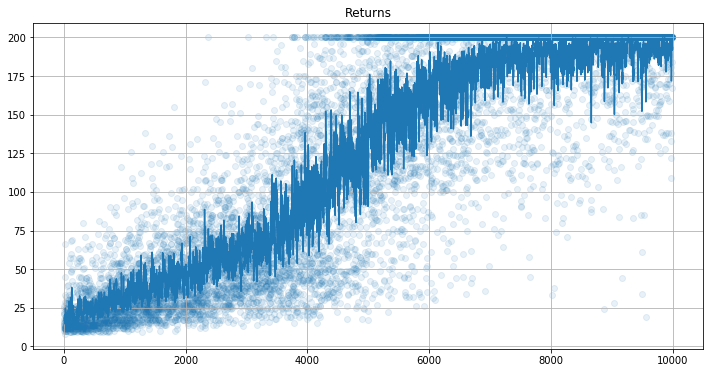

In [22]:
returns_history = []

for i in range(NUM_BATCHES):
    
    traj_batch = []

    for j in range(NUM_EPISODES):
        
        traj = []
        
        state = env.reset()
        done = False
        
        rewards = 0

        while not done:
            with torch.no_grad():
                state = torch.FloatTensor(state).to(device)
                probs = policy(state)
                dist = Categorical(probs)
                action = dist.sample()
                next_state, reward, done, _ = env.step(action.item())
            
            traj.append(transition(state=state, action=action, reward=reward))

            state = next_state
            
            rewards += reward
        
        returns_history.append(rewards)
            
        traj_batch.append(traj)
        
    log_probs, returns = process_traj_batch(policy, traj_batch, DISCOUNT)
    
    loss = -(torch.stack(log_probs) * torch.FloatTensor(returns).to(device)).sum()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step() 


    if i % 10:
        clear_output(True)
        plt.figure(figsize=[12, 6])
        plt.title('Returns'); plt.grid()
        plt.scatter(np.arange(len(returns_history)), returns_history, alpha=0.1)
        plt.plot(moving_average(returns_history, span=10, min_periods=10))
        plt.show()

Протестируем и визуализируем обученного агента.

In [23]:
test_agent(env, agent=policy, render=True, n_episodes=100)

Episode 1 finished after 149 timesteps
Episode 2 finished after 149 timesteps
Episode 3 finished after 190 timesteps
Episode 4 finished after 201 timesteps
Episode 5 finished after 201 timesteps
Episode 6 finished after 46 timesteps
Episode 7 finished after 172 timesteps
Episode 8 finished after 182 timesteps
Episode 9 finished after 201 timesteps
Episode 10 finished after 201 timesteps
Episode 11 finished after 137 timesteps
Episode 12 finished after 201 timesteps
Episode 13 finished after 201 timesteps
Episode 14 finished after 201 timesteps
Episode 15 finished after 201 timesteps
Episode 16 finished after 148 timesteps
Episode 17 finished after 145 timesteps
Episode 18 finished after 201 timesteps
Episode 19 finished after 198 timesteps
Episode 20 finished after 201 timesteps
Episode 21 finished after 201 timesteps
Episode 22 finished after 201 timesteps
Episode 23 finished after 201 timesteps
Episode 24 finished after 149 timesteps
Episode 25 finished after 201 timesteps
Episode 26

186.84

Как видно, обученный агент играет очень хорошо и приближается к искомому среднему значению средней награды за 100 эпизодов 195. 

### REINFORCE with baselines (Опционально)

В лекциях вы слышали, что при расчете градиентов для обновления параметров политики агента мы можем вычесть зи суммы дисконтированных наград ```baseline``` для уменьшения дисперсии градиентов и ускорения сходимости обучения - такой алгоритм называется REINFORCE with baselines. В качестве ```baseline``` мы можем использовать другую нейронную сеть, которая будет оценивать сумму дисконтированных наград из данного состояния *V(s)*. 

Схема алгоритма REINFORCE with baselines (Sutton & Barto) <img src="./images/REINFORCE_with_baselines.png" width="700">

**Задание**: Включите в уже разработанный алгоритм вторую нейронную сеть для оценки суммы дисконтированных наград *V(s)*. Используйте разницу между фактической суммой дисконтированных наград и оценкой в формуле функции потерь политики. В качестве функции потерь для *V(s)* используйте ```torch.nn.MSELoss```. Оцените скорость сходимости нового алгоритма.